In [1]:
import contextily
import geopandas
import rioxarray
import seaborn
import pandas
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry

We first consider different approaches to construct spatial weights, distinguishing between those based on **contiguity/adjacency** relations from weights obtained from **distance based** relationships. We then discuss the case of hybrid weights which combine one or more spatial operations in deriving the neighbor relationships between observations. We illustrate all of these concepts through the spatial weights class in pysal, which provides a rich set of methods and characteristics for spatial weights and it is stored under the weights sub-module:

In [2]:
from pysal.lib import weights

# 1. Contiguity weights
A contiguous pair of spatial objects are those that share a common border. Let’s start with the example of a three-by-three grid. We can create it as a geo-table from scratch:

In [3]:
# Get points in a grid
l = numpy.arange(3)
xs, ys = numpy.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)

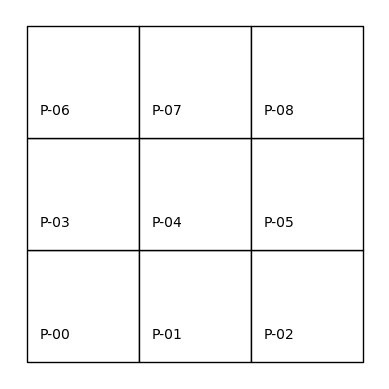

In [4]:
# Plot grid geotable
ax = gdf.plot(facecolor="w", edgecolor="k")

# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )

# Remove axes
ax.set_axis_off()
plt.show()

## 1.1 Rook contiguity
**Rook** contiguity requires that the pair of polygons in question share an edge. According to this definition, polygon 0 would be a Rook neighbor of 1 and 3, while 1 would be a Rook neighbor with 0, 2, and 4. Applying this rule to all nine polygons we can model our neighbor relations as:

In [13]:
# Build a rook contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wr = weights.contiguity.Rook.from_dataframe(gdf)

C:\Users\AX\AppData\Local\Temp\ipykernel_21648\3474591331.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wr = weights.contiguity.Rook.from_dataframe(gdf)


We can visualize the spatial weight result plotted on top of the same grid of labeled polygons, using red dotted lines to represent the edges between a pair of nodes (polygon centroids in this case).

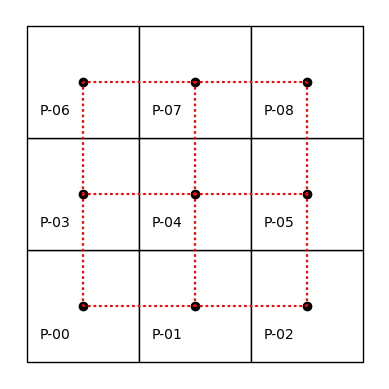

In [12]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

The neighbors attribute of our pysal object encodes the neighbor relationships by expressing the focal observation on the left (in the key of the dictionary), and expressing the neighbors to the focal in the list on the right (in the value of the dictionary). This representation has computational advantages, as it exploits the sparse nature of contiguity weights matrices by recording only non-zero weights:

In [14]:
wr.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

More specifically, there is no reason to store the “non-neighbor” information and this results in significant reductions in memory requirements. However, it is possible to create the fully dense, matrix representation if needed:

In [22]:
pandas.DataFrame(*wr.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


## 1.2 Queen contiguity
Polygons 0 and 5 are not Rook neighbors, but they do in fact share a common border. However, in this instance the sharing is due to a common *vertex* rather than a shared *edge*. If we wanted them to be considered as neighbours, we can switch to the more inclusive notion of Queen contiguity, which requires the pair of polygons to only share one or more vertices. We can create the neighbor relations for this same configuration as follows:

In [25]:
# Build a queen contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wq = weights.contiguity.Queen.from_dataframe(gdf)
wq.neighbors

C:\Users\AX\AppData\Local\Temp\ipykernel_21648\736973915.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = weights.contiguity.Queen.from_dataframe(gdf)


{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

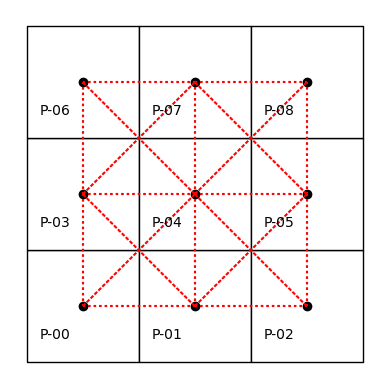

In [27]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

Akin to how the neighbors dictionary encodes the contiguity relations, the weights dictionary encodes the strength of the link connecting the focal to each neighbor. For contiguity weights, observations are usually either considered “linked” or “not linked,” so the resulting weights matrix is binary. As in any pysal W object, the actual weight values are contained in the weights attribute:

In [28]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

It is important to note that the **weights** and **neighbors** are aligned with one another; for each observation, its first neighbor in neighbors has the first weight in its weights entry.

The **w** object has a large number of other attributes and methods that can be useful. 

In [29]:
# The cardinalities attribute reports the number of neighbors for each observation:
wq.cardinalities

{0: 3, 1: 5, 2: 3, 3: 5, 4: 8, 5: 5, 6: 3, 7: 5, 8: 3}

In [30]:
# The related histogram attribute provides an overview of the distribution of these cardinalities:
wq.histogram

[(3, 4), (4, 0), (5, 4), (6, 0), (7, 0), (8, 1)]

In [35]:
# wq.pct_nonzero = 100 * (w.s0/w.n^2)
print(wq.s0, wq.n, wq.pct_nonzero)

40.0 9 49.382716049382715


## 1.3 A practice

In [36]:
san_diego_tracts = geopandas.read_file(
    r'D:\OneDrive - Nexus365\1-Oxford\2 - DPhil project\2024.03.31 Employment and residential centres in Shanghai\2-data/sandiego_tracts.gpkg'
)
w_queen = weights.contiguity.Queen.from_dataframe(san_diego_tracts)

C:\Users\AX\AppData\Local\Temp\ipykernel_21648\807833518.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = weights.contiguity.Queen.from_dataframe(san_diego_tracts)


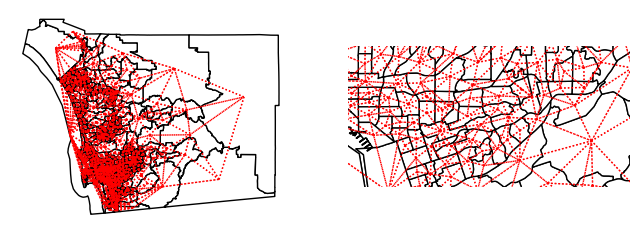

In [37]:
# Plot tract geography
f, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax = san_diego_tracts.plot(
        edgecolor="k", facecolor="w", ax=axs[i]
    )
    # Plot graph connections
    w_queen.plot(
        san_diego_tracts,
        ax=axs[i],
        edge_kws=dict(color="r", linestyle=":", linewidth=1),
        node_kws=dict(marker=""),
    )
    # Remove the axis
    axs[i].set_axis_off()
axs[1].axis([-13040000, -13020000, 3850000, 3860000]);

# 2. Distance based weights
We can also define neighbor relations as a function of the distance separating spatial observations. Usually, this means that a matrix expressing the distances between all pairs of observations are required. These are then provided to a kernel function which uses the proximity information to model proximity as a smooth function of distance.

$pysal$ implements a family of distance functions. Here we illustrate a selection beginning with the notion of nearest neighbor weights.
## 2.1 K-nearest neighbor weights
The first type of distance based weights defines the neighbor set of a particular observation as containing its nearest observations, where the user specifies the value of k=4. To illustrate this for the San Diego tracts, we take . This still leaves the issue of how to measure the distance between these polygon objects, however. To do so we develop a representative point for each of the polygons using the centroid.

In [38]:
wk4 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=4)

In [ ]:
The k-nearest neighbor weights displays no island problem, that is everyone has at least one neighbor.Everyone has the same number of neighbors. In some cases, this is not an issue but a desired feature. In other contexts, however, this characteristic of k-nearest neighbor weights can be undesirable. In such situations, we can turn to other types of distance-based weights.

In [40]:
print(wk4.islands)
print(wk4.histogram)

[]
[(4, 628)]


## 2.2 Kernel weights
The k-nearest neighbor rule assigns binary values to the weights for neighboring observations. $pysal$ also supports continuously valued weights: observations that are close to a unit have larger weights than more distant observations.The essence of kernel weights is that the weight between observations $i$ and $j$ is based on their distance, but it is further modulated by a kernel function with certain properties.

The simplest way to compute Kernel weights in $pysal$ is as following:

In [43]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

The value of the weights will be a function of two main options for kernel weights: choice of kernel function and bandwidth. The former controls how distance between $i$ and $j$ is “modulated” to produce the weight that goes in $wij$.In this respect, $pysal$ offers a large number of functions that determine the shape of the distance decay function. The bandwidth specifies the distance from each focal unit over which the kernel function is applied. For observations separated by distances larger than the bandwidth, the weights are set to zero.

The default values for kernels are to use a triangular kernel with a bandwidth distance equal to the maximum knn=2 (k-nearest neighbors?) distance for all observations. The latter implies a so-called fixed bandwidth where all observations use the same distance for the cut-off. We can inspect this from the generated $w$ object:

In [44]:
w_kernel.function

'triangular'

In [45]:
# Show the first five values of bandwidths
w_kernel.bandwidth[0:5]

array([[1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001]])

A fixed bandwidth is not always the best choice. For example, in cases where the density of the observations varies over the study region, using the same threshold anywhere will result in regions with a high density of neighbors while others with observations very sparsely connected. In these situations, an $adaptive$ bandwidth -one which varies by observation and its characteristics- can be preferred.

Adaptive bandwidths are picked again using a K-nearest neighbor rule. A bandwidth for each observation is chosen such that, once the 
k-nearest observation is considered, all the remaining observations have zero weight.Here is an example:

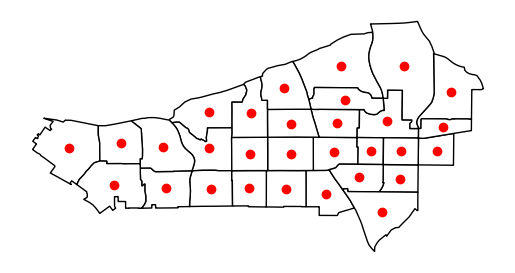

In [52]:
# Create subset of tracts
sub_30 = san_diego_tracts.query("sub_30 == True")
# Plot polygons
ax = sub_30.plot(facecolor="w", edgecolor="k")
# Create and plot centroids
sub_30.centroid.plot(color="r", ax=ax)
# Remove axis
ax.set_axis_off();

If we now build a weights object with adaptive bandwidth ($fixed=False$), the values for bandwidth differ:

In [53]:
# Build weights with adaptive bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(
    sub_30, fixed=False, k=15
)
# Print first five bandwidth values
w_adaptive.bandwidth[:5]

array([[7065.74020822],
       [3577.22591841],
       [2989.74807871],
       [2891.46196945],
       [3965.08354232]])

And, we can visualize what these kernels look like on the map, too, by focusing on an individual unit and showing how the distance decay attenuates the weight by grabbing the corresponding row of the full kernel matrix:

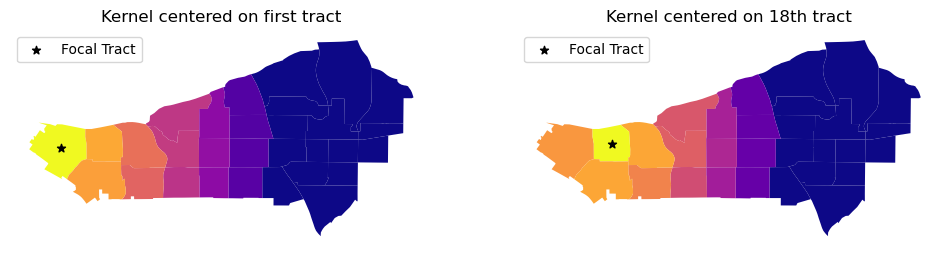

In [54]:
# Create full matrix version of weights
full_matrix, ids = w_adaptive.full()
# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 2, figsize=(12, 6), subplot_kw=dict(aspect="equal")
)
# Append weights for first polygon and plot on first subplot
sub_30.assign(weight_0=full_matrix[0]).plot(
    "weight_0", cmap="plasma", ax=ax[0]
)
# Append weights for 18th polygon and plot on first subplot
sub_30.assign(weight_18=full_matrix[17]).plot(
    "weight_18", cmap="plasma", ax=ax[1]
)
# Add centroid of focal tracts
sub_30.iloc[[0], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[17], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
# Add titles
ax[0].set_title("Kernel centered on first tract")
ax[1].set_title("Kernel centered on 18th tract")
# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

## 2.3 Distance bands and hybrid Weights
In some contexts, it makes sense to draw a circle around each observation and consider as neighbors every other observation that falls within the circle. If they are, they are assigned a weight of one in the spatial weights matrix; if not they receive a zero.

In [58]:
# The following code creates a binary distance weights where every other observation within a distance of 1.5 is considered neighbor
w_bdb = weights.distance.DistanceBand.from_dataframe(
    gdf, 1.5, binary=True
)

Distance band weights can also be continuously weighted. These could be seen as a kind of “censored” kernel, where the kernel function is applied only within a pre-specified distance. 

In [57]:
w_hy = weights.distance.DistanceBand.from_dataframe(
    gdf, 1.5, binary=False
)

C:\Users\AX\anaconda3\Lib\site-packages\scipy\sparse\_data.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


## 2.4 Block weights
Block weights connect every observation in a dataset that belongs to the same category in a provided list. In essence, a block weight structure groups individual observations and considers all members of the group as “near” one another. This means that they then have a value of one for every pair of observations in the same group. Contrariwise, all members not in that group are considered disconnected from any observation within the group, and given a value of zero.

In [59]:
# NOTE: since this is a large dataset, it might take a while to process
w_bl = weights.util.block_weights(
    san_diego_tracts["county"].values,
    ids=san_diego_tracts["GEOID"].values,
)

## 2.5 Set operations on weights
Suppose, for example, the researcher wanted to allow for Queen neighbors within counties but not for tracts across different counties. In this case, tracts from different counties would not be considered neighbors. To create such as spatial weights matrix would require a combination of the Queen and the block criteria, and $pysal$ can implement that blending through one of the set operations.

In this example, we will generate a combination of the original contiguity weights and the nearest neighbor weights. We will examine two different approaches that provide similar solutions, thus illustrating the value of set operations

### 2.5.1 Editing/connecting disconnected observations
Imagine one of our tracts was an island and did not have any neighbors in the contiguity case. This can create issues in the spatial analytics that build on spatial weights, so it is good practice to amend the matrix before using it. The first approach we adopt is to find the nearest neighbor for the island observation and then add this pair of neighbors to extend the neighbor pairs from the original contiguity weight to obtain a fully connected set of weights.

We will assume, for the sake of the example, that the disconnected observation was number 103. For us to reattach this tract, we can assign it to be “connected” to its nearest neighbor. Let’s first extract our “problem” geometry:

In [64]:
disconnected_tract = san_diego_tracts.iloc[[103]]
w_queen[103]

{160: 1.0, 480: 1.0, 98: 1.0, 324: 1.0, 102: 1.0, 107: 1.0, 173: 1.0}

As we have seen above, this tract **does** have neighbors. But, for this example, we will assume it does not. We will connect the observation to its nearest neighbor. To do this, we can construct the KNN graph as we did above, but set $k=1$, so observations are only assigned to their nearest neighbor:

In [65]:
wk1 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=1)

C:\Users\AX\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 153 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [67]:
wk1.neighbors[103]

[102]

To connect it in our initial matrix, we need to create a copy of the neighbors dictionary and update the entry for $103$, including $102$ as a neighbor. Then we change the entry for the island observation to include its nearest neighbor ($102$) as well as update $102$ to have $103$ as a neighbor.

In [68]:
neighbors = w_queen.neighbors.copy()
neighbors[103].append(102)
neighbors[102].append(103)
w_new = weights.W(neighbors)
w_new[103]

{160: 1.0, 480: 1.0, 98: 1.0, 324: 1.0, 102: 1.0, 107: 1.0, 173: 1.0}

### 2.5.2 Using the $union$ of matrices
A more elegant approach to the island problem makes use of $pysal$’s support for *set theoretic operations* on $pysal$ weights. For example, we can construct the *union* of two weighting schemes, connecting any pair of observations if they are connected in either the Queen or if they are nearest neighbors.

It is important to mention that this approach is not exactly the same, at least in principle, as the one above. It could be that the nearest observation was not originally a Rook neighbor and, in this case, the resulting matrices would differ. 

In [70]:
w_fixed_sets = weights.set_operations.w_union(w_queen, wk1)

### 2.5.3 Visualizing weight set operations
We compare the neighbor graphs that results from some of the criteria introduced to define neighbor relations. 

In [73]:
mx = geopandas.read_file(r'D:\OneDrive - Nexus365\1-Oxford\2 - DPhil project\2024.03.31 Employment and residential centres in Shanghai\2-data\mexico\mexicojoin.shp')

In [74]:
mx_queen = weights.contiguity.Queen.from_dataframe(mx)
mx_knn4 = weights.KNN.from_dataframe(mx, k=4)
mx_bw = weights.util.block_weights(mx["INEGI2"].values)
mx_union = weights.set_operations.w_union(mx_bw, mx_queen)

C:\Users\AX\AppData\Local\Temp\ipykernel_21648\1952374191.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  mx_queen = weights.contiguity.Queen.from_dataframe(mx)
C:\Users\AX\anaconda3\Lib\site-packages\libpysal\weights\util.py:296: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  w = W(neighbors, **kwargs)


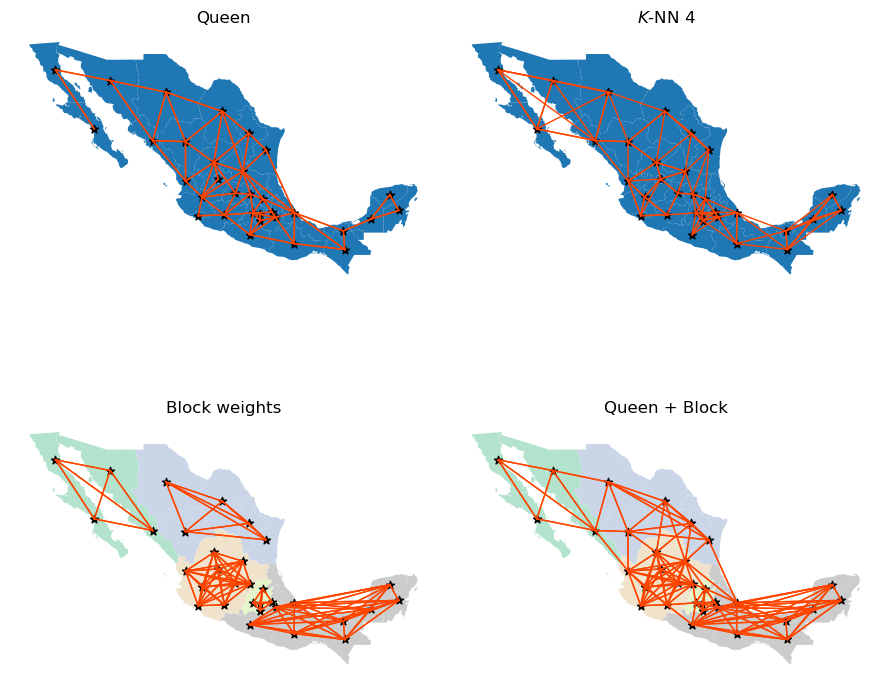

In [75]:
# Set up figure and axis
f, axs = plt.subplots(2, 2, figsize=(9, 9))

# Contiguity
ax = axs[0, 0]
mx.plot(ax=ax)
mx_queen.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("Queen")

# KNN
ax = axs[0, 1]
mx.plot(ax=ax)
mx_knn4.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("$K$-NN 4")

# Block
ax = axs[1, 0]
mx.plot(column="INEGI2", categorical=True, cmap="Pastel2", ax=ax)
mx_bw.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("Block weights")

# Union
ax = axs[1, 1]
mx.plot(column="INEGI2", categorical=True, cmap="Pastel2", ax=ax)
mx_union.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("Queen + Block")
f.tight_layout()
plt.show()